In [52]:
import numpy as np
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from numpy.linalg import qr
import scipy
import seaborn as sns


# Multipartite Entanglement of Assistance
##### note: L^tau_global(|Psi>) = F(Psi_B, Psi_B~)

In [22]:
def qr_haar(N):
    A, B = np.random.normal(size=(N, N)), np.random.normal(size=(N, N))
    Z = A + 1j * B
    Q, R = qr(Z)
    Lambda = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(N)])
    U = np.dot(Q, Lambda)
    return U[:,0] 

# Step One: Get Psi_B by tracing out A from Psi_AB
def get_Psi_B(psi_AB, n_A, n_B):
    d_A = 2**n_A
    d_B = 2**n_B
    rho_AB = np.outer(psi_AB, np.conjugate(psi_AB))
    rho_B = np.zeros((d_B, d_B), dtype=complex)
    for i in range(d_A):
        for j in range(d_A):
            rho_B += rho_AB[i*d_B:(i+1)*d_B, j*d_B:(j+1)*d_B] * (i == j)
    return rho_B
# Step Two: Get Psi_B~ by spin-flipping Psi_B
def spin_flip(rho_B, n_B):
    # single-qubit sigma_y
    sy = np.array([[0, -1j],[1j, 0]])
    # build sigma_y^{⊗n_B}
    Sy = sy
    for _ in range(n_B-1):
        Sy = np.kron(Sy, sy)
    # spin-flipped state
    rho_B_star = np.conjugate(rho_B)
    rho_B_tilde = Sy @ rho_B_star @ Sy
    return rho_B_tilde
# Step Three: Compute the fidelity F(Psi_B, Psi_B~)
def fidelity(rho_B, rho_B_tilde):
    sqrt_rho_B = scipy.linalg.sqrtm(rho_B)
    product = sqrt_rho_B @ rho_B_tilde @ sqrt_rho_B
    sqrt_product = scipy.linalg.sqrtm(product)
    F = np.trace(sqrt_product).real**2
    return F
# Final function: Compute L_tau_global(|Psi>) = F(Psi_B, Psi_B~)
def L_tau_global(psi_AB, n_A, n_B):
    rho_B = get_Psi_B(psi_AB, n_A, n_B)
    rho_B_tilde = spin_flip(rho_B, n_B)
    F = fidelity(rho_B, rho_B_tilde)
    return F

def estimate_MEA(nA, nB, N_samples=100):
    Ls = np.zeros(N_samples)
    for i in range(N_samples):
        psi = qr_haar(2**(nA + nB))  # Haar random state
        Li = L_tau_global(psi, nA, nB)
        Ls[i] = Li
    return Ls.mean(), Ls.std()

def MEA_vs_DB(nA, nB_values, N_samples=200):
    means, stds = [], []
    for nB in nB_values:
        mean, std = estimate_MEA(nA, nB, N_samples)
        means.append(mean)
        stds.append(std)
    return np.array(means), np.array(stds)


def MEA_vs_DA(nAs, nB, N_samples=200):
    means, stds = [], []
    for nA in nAs:
        mean, std = estimate_MEA(nA, nB, N_samples)
        means.append(mean)
        stds.append(std)
    return np.array(means), np.array(stds)



In [40]:
sns.set_theme()

# Work for Corollary 21

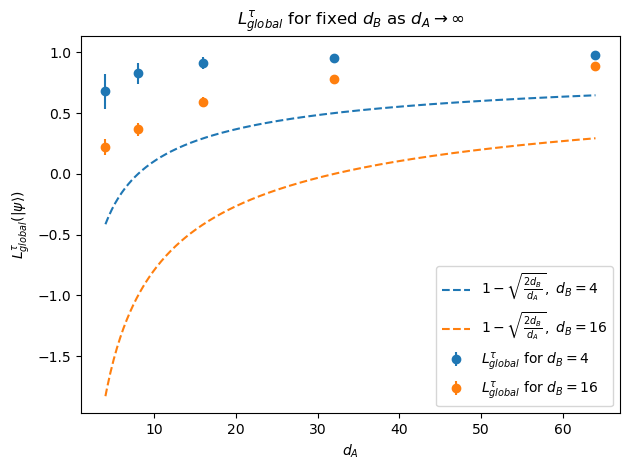

In [38]:
# MEA for fixed dB, inc dA
nB = 2
nB2 = 4

def bound(dB, dA):
    return 1 - ((2*dB)/dA)**0.5

nA = list(range(2, 7))
dA = 2**np.array(nA)

# Unpack (means, stds)
means, stds = MEA_vs_DA(nA, nB, N_samples=1000)
means2, stds2 = MEA_vs_DA(nA, nB2, N_samples=1000)

dA_dense = np.linspace(dA.min(), dA.max(), 300)
bound1 = np.array([bound(4, d) for d in dA_dense])
bound2 = np.array([bound(16, d) for d in dA_dense])

plt.errorbar(dA, means, yerr=stds, fmt='o', color='C0',
             label=r'$L^{\tau}_{global}$ for $d_B = 4$')
plt.errorbar(dA, means2, yerr=stds2, fmt='o', color='C1',
             label=r'$L^{\tau}_{global}$ for $d_B = 16$')

plt.plot(dA_dense, bound1, 'C0--',
         label=r'$1 - \sqrt{\frac{2d_B}{d_A}}, \ d_B = 4$')
plt.plot(dA_dense, bound2, 'C1--',
         label=r'$1 - \sqrt{\frac{2d_B}{d_A}}, \ d_B = 16$')

plt.xlabel(r'$d_A$')
plt.ylabel(r'$L^{\tau}_{global}(|\psi\rangle)$')
plt.title(r'$L^{\tau}_{global}$ for fixed $d_B$ as $d_A \rightarrow \infty$')
plt.legend()
plt.tight_layout()
plt.show()


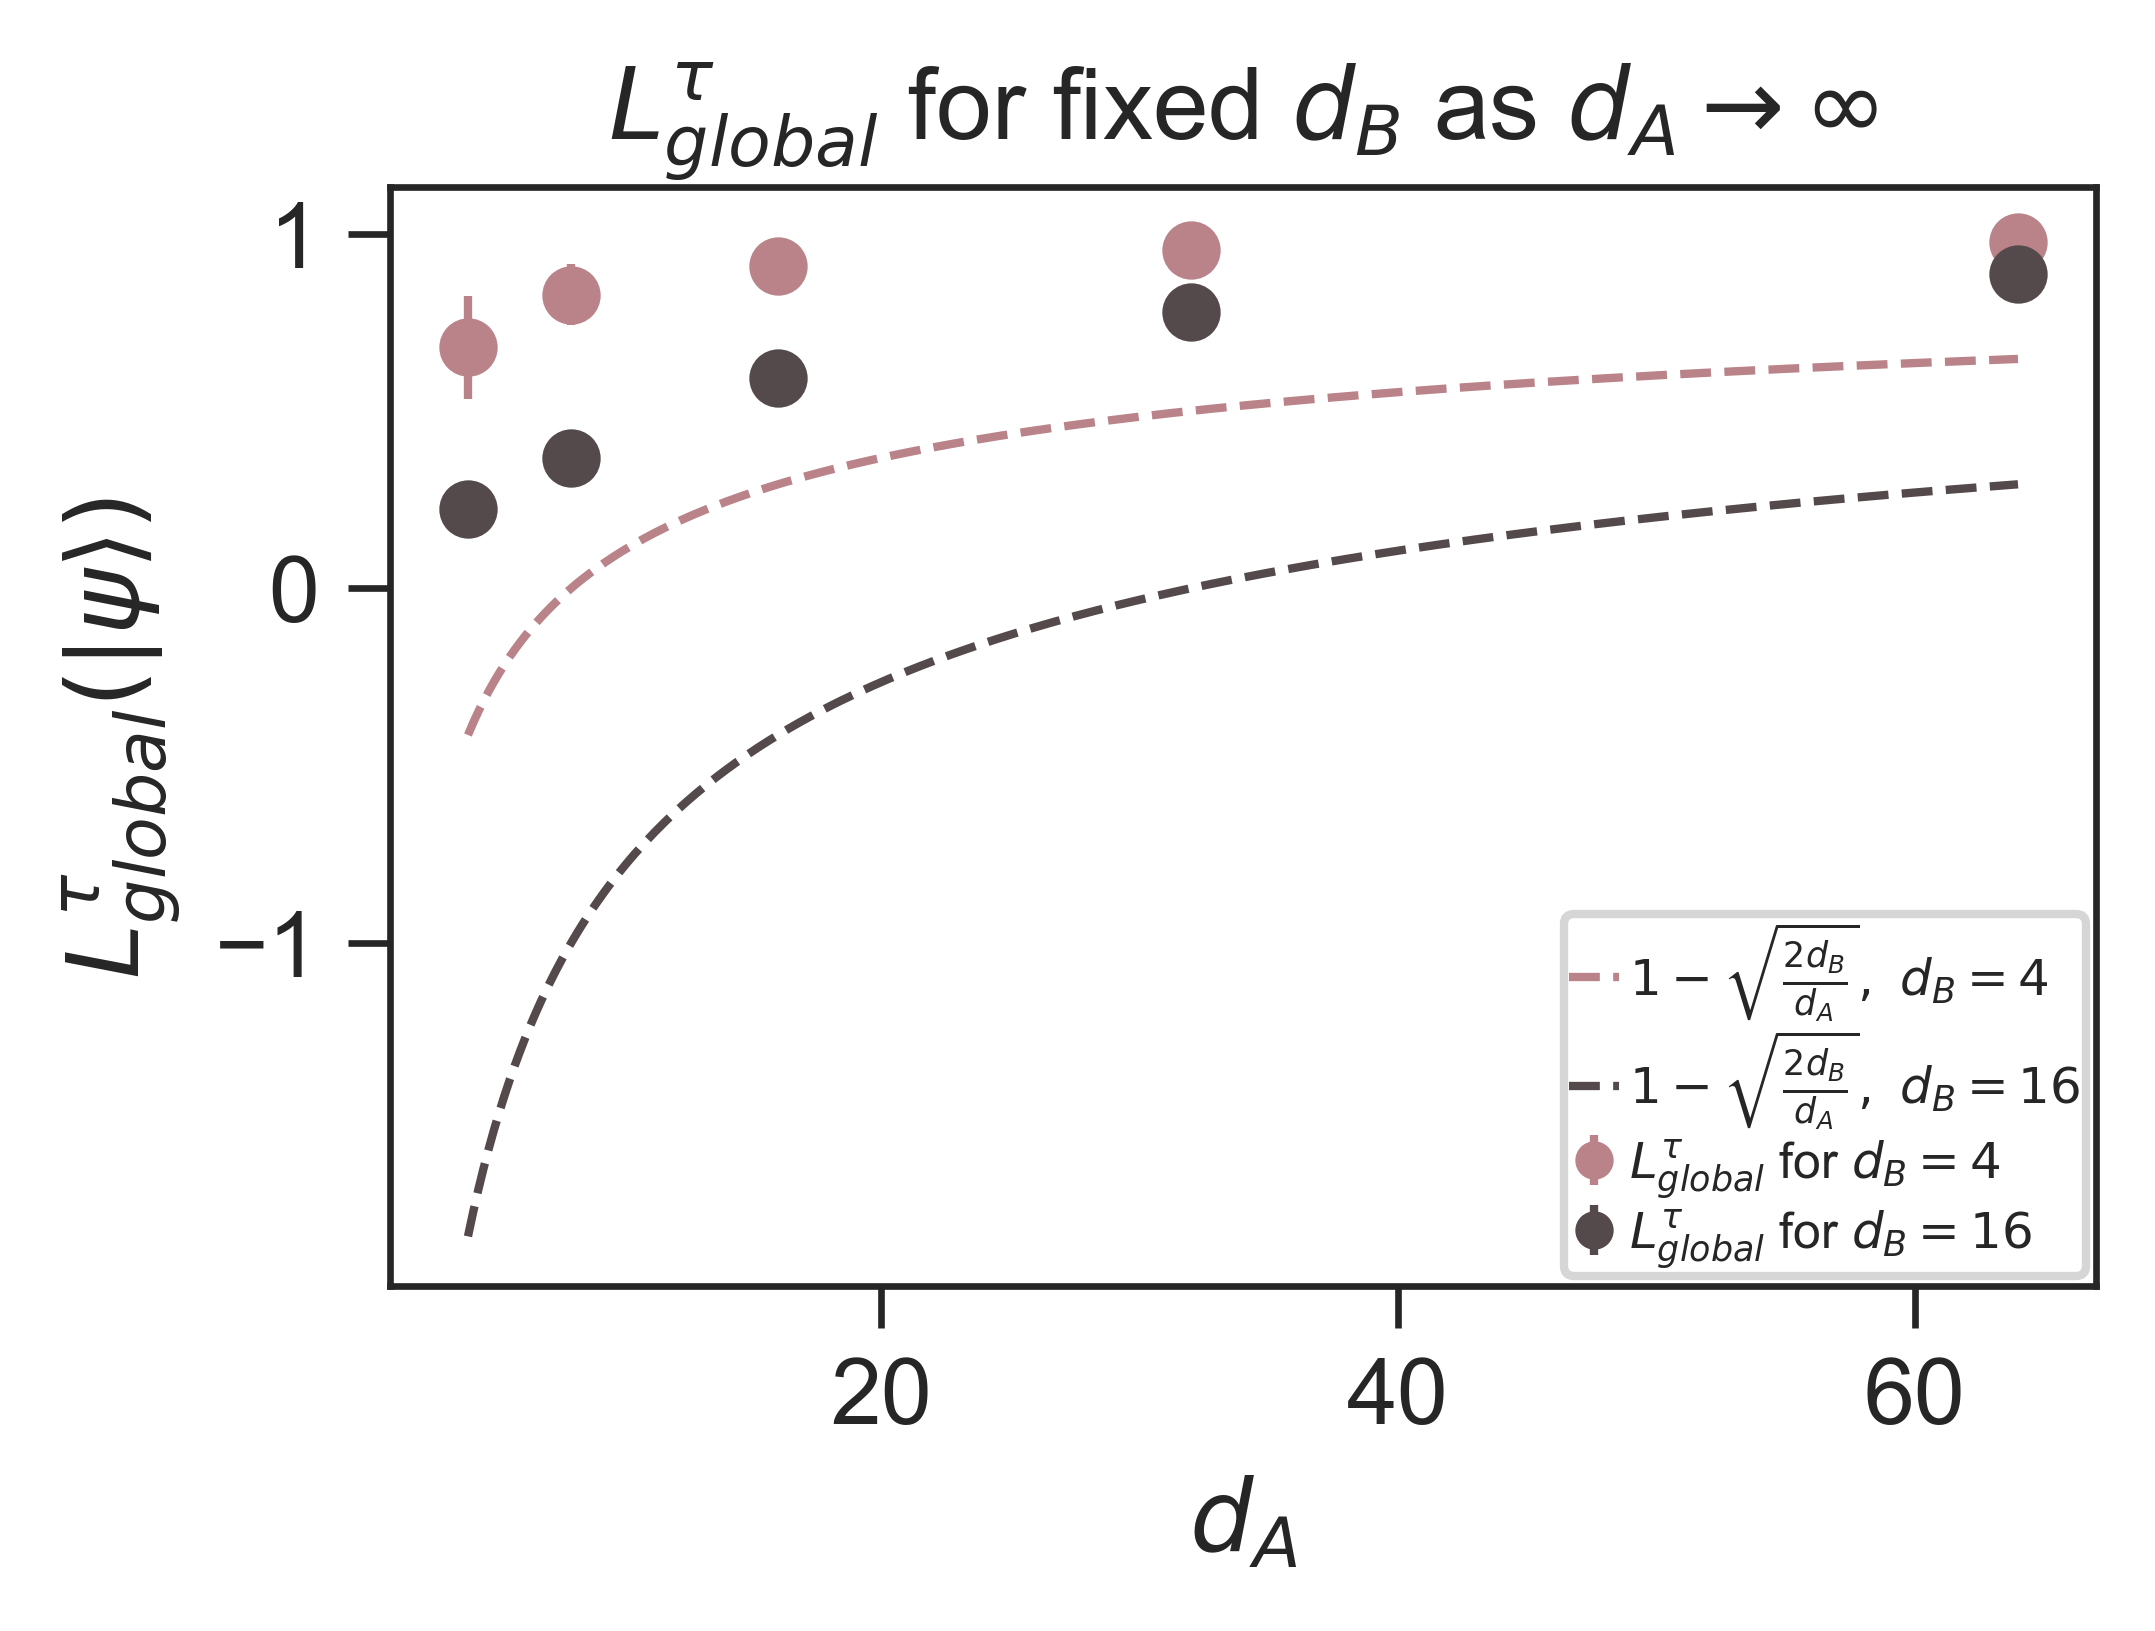

In [57]:
# Style
sns.set(rc={"figure.dpi": 600, 'savefig.dpi': 600})
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1})
sns.set_palette(['#B98389', '#54494B', '#9DA39A'], n_colors=100)

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })
plt.rcParams.update({
     "font.family": "serif", 
     "font.serif": ["Times New Roman"], # Times Roman for all text 
     "font.size": 16, "text.usetex": False # MathText only 
     })
# ---------------- Functions ---------------- #
def bound(dB, dA):
    return 1 - np.sqrt((2 * dB) / dA)

# ---------------- Data ---------------- #
# Example: dA, means, stds, means2, stds2 should be precomputed before this script
dA_dense = np.linspace(dA.min(), dA.max(), 300)
bound1 = bound(4, dA_dense)
bound2 = bound(16, dA_dense)

# ---------------- Plot ---------------- #
f = plt.figure(figsize=(4, 3))
gs = f.add_gridspec(1, 1)

with sns.axes_style("ticks", {'axes.grid': False, 'grid.color': '0.9', 'font.family': 'Arial'}):
    ax = f.add_subplot(gs[0, 0])

    # Error bars
    ax.errorbar(dA, means, yerr=stds, fmt='o', color=sns.color_palette()[0],
                label=r'$L^{\tau}_{global}$ for $d_B = 4$')
    ax.errorbar(dA, means2, yerr=stds2, fmt='o', color=sns.color_palette()[1],
                label=r'$L^{\tau}_{global}$ for $d_B = 16$')

    # Bounds
    ax.plot(dA_dense, bound1, linestyle="--", color=sns.color_palette()[0],
            label=r'$1 - \sqrt{\frac{2d_B}{d_A}}, \ d_B = 4$')
    ax.plot(dA_dense, bound2, linestyle="--", color=sns.color_palette()[1],
            label=r'$1 - \sqrt{\frac{2d_B}{d_A}}, \ d_B = 16$')

    # Labels
    ax.set_xlabel(r'$d_A$')
    ax.set_ylabel(r'$L^{\tau}_{global}(|\psi\rangle)$')
    ax.set_title(r'$L^{\tau}_{global}$ for fixed $d_B$ as $d_A \rightarrow \infty$')

    # Legend
    ax.legend(fontsize=6,            
              frameon=True,
              borderpad=0.1,          
              labelspacing=0.1,   
              handlelength=1.0,  
              handletextpad=0.2,    
              markerscale=0.6,       
              borderaxespad=0.2,     
              loc="best")

    # Axis formatting
    ax.tick_params(which='both', width=0.8)
    ax.tick_params(which='major', length=5)
    ax.tick_params(which='minor', length=2.5)
    for spine in ["bottom", "top", "left", "right"]:
        ax.spines[spine].set_linewidth(0.8)

f.tight_layout()

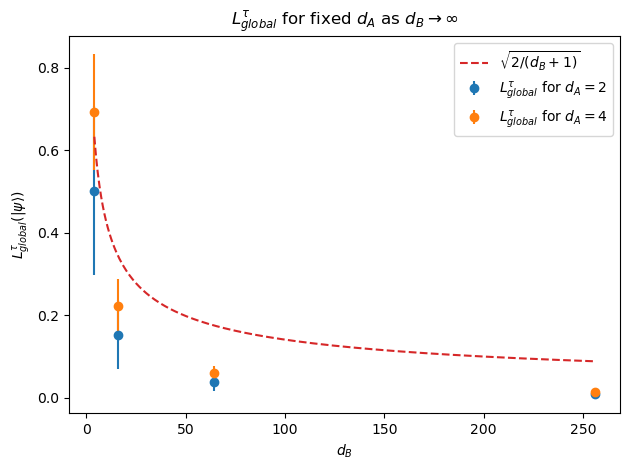

In [ ]:
# MEA for fixed dA, inc dB
nA = 1
nA2 = 2

def bound2(dB):
    return np.sqrt(2/(dB + 1))

nB = list(range(2, 9, 2))
dB = 2**np.array(nB)

# Now MEA_vs_DB returns (means, stds)
meansdA, stdsdA = MEA_vs_DB(nA, nB, N_samples=1000)
means2dA, stds2dA = MEA_vs_DB(nA2, nB, N_samples=1000)

plt.errorbar(dB, means, yerr=stds, fmt='o', color='C0',
             label=r'$L^{\tau}_{global}$ for $d_A = 2$')
plt.errorbar(dB, means2, yerr=stds2, fmt='o', color='C1',
             label=r'$L^{\tau}_{global}$ for $d_A = 4$')

dB_dense = np.linspace(dB.min(), dB.max(), 300)
plt.plot(dB_dense, bound2(dB_dense), 'C3--',
         label=r'$\sqrt{2/(d_B + 1)}$')

plt.xlabel(r'$d_B$')
plt.ylabel(r'$L^{\tau}_{global}(|\psi\rangle)$')
plt.title(r'$L^{\tau}_{global}$ for fixed $d_A$ as $d_B \rightarrow \infty$')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- Style ---------------- #
sns.set(rc={"figure.dpi": 600, 'savefig.dpi': 600})
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1})
sns.set_palette(['#B98389', '#54494B', '#9DA39A'], n_colors=100)
plt.rcParams.update({
     "font.family": "serif", 
     "font.serif": ["Times New Roman"], # Times Roman for all text 
     "font.size": 16, "text.usetex": False # MathText only 
     })

# ---------------- Functions ---------------- #
def bound2(dB):
    return np.sqrt(2 / (dB + 1))

# ---------------- Data ---------------- #
nA = 1
nA2 = 2
nB = list(range(2, 9, 2))
dB = 2 ** np.array(nB)

dB_dense = np.linspace(dB.min(), dB.max(), 300)
bound_curve = bound2(dB_dense)

# ---------------- Plot ---------------- #
f = plt.figure(figsize=(4, 3))
gs = f.add_gridspec(1, 1)

with sns.axes_style("ticks", {'axes.grid': False, 'grid.color': '0.9', 'font.family': 'Arial'}):
    ax = f.add_subplot(gs[0, 0])

    # Error bars
    ax.errorbar(dB, meansdA, yerr=stdsdA, fmt='o', color=sns.color_palette()[0],
                label=r'$L^{\tau}_{global}$ for $d_A = 2$')
    ax.errorbar(dB, means2dA, yerr=stds2dA, fmt='o', color=sns.color_palette()[1],
                label=r'$L^{\tau}_{global}$ for $d_A = 4$')

    # Bound curve
    ax.plot(dB_dense, bound_curve, linestyle="--", color=sns.color_palette()[2],
            label=r'$\sqrt{2/(d_B + 1)}$')

    # Labels
    ax.set_xlabel(r'$d_B$')
    ax.set_ylabel(r'$L^{\tau}_{global}(|\psi\rangle)$')
    ax.set_title(r'$L^{\tau}_{global}$ for fixed $d_A$ as $d_B \rightarrow \infty$')

    # Legend (extra tiny & compact)
    ax.legend(fontsize=6,
              frameon=True,
              borderpad=0.1,
              labelspacing=0.1,
              handlelength=1.0,
              handletextpad=0.2,
              markerscale=0.6,
              borderaxespad=0.2,
              loc="best")

    # Axis formatting
    ax.tick_params(which='both', width=0.8)
    ax.tick_params(which='major', length=5)
    ax.tick_params(which='minor', length=2.5)
    for spine in ["bottom", "top", "left", "right"]:
        ax.spines[spine].set_linewidth(0.8)

f.tight_layout()

KeyboardInterrupt: 

In [26]:
def p(N_A, N_B, epsilon = 0.05):
    d_B = 2**N_B
    d_A = 2**N_A
    a = (40 * ( 2 * np.sqrt(2) + 1)**2 * N_A**2 * d_A**2 * d_B**2) / (epsilon**2)
    b = 8 * N_A * np.log(a)
    c = (d_A*d_B * epsilon**2) / (18* np.pi**3 * (4 * np.sqrt(2) + 2)**2)
    return np.exp(np.log(2) + b - c)



0.0


/var/folders/qw/y11njw5s5mgdwtp_fhhbw7x80000gn/T/ipykernel_57916/212532999.py:7: RuntimeWarning: overflow encountered in exp
  return np.exp(np.log(2) + b - c)
/var/folders/qw/y11njw5s5mgdwtp_fhhbw7x80000gn/T/ipykernel_57916/212532999.py:5: RuntimeWarning: divide by zero encountered in log
  b = 8 * N_A * np.log(a)
/var/folders/qw/y11njw5s5mgdwtp_fhhbw7x80000gn/T/ipykernel_57916/212532999.py:6: RuntimeWarning: overflow encountered in scalar multiply
  c = (d_A*d_B * epsilon**2) / (18* np.pi**3 * (4 * np.sqrt(2) + 2)**2)


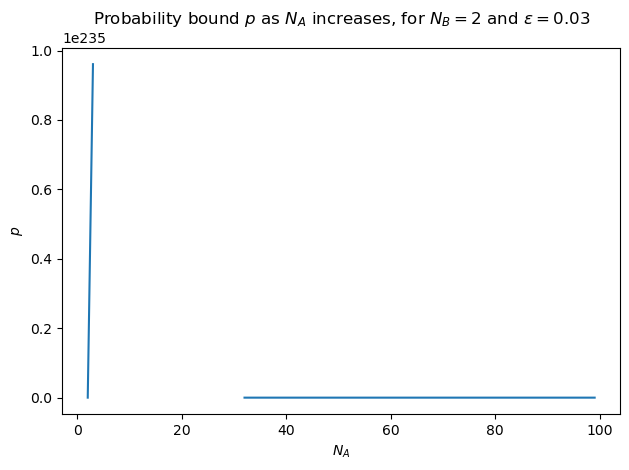

In [36]:
print(p(N_A = 40, N_B = 10))
N_As = np.arange(2, 100)
ps = [p(N_A, N_B = 2, epsilon = 0.03) for N_A in N_As]
plt.plot(N_As, ps)
plt.xlabel(r'$N_A$')
plt.ylabel(r'$p$')
plt.title(r'Probability bound $p$ as $N_A$ increases, for $N_B = 2$ and $\epsilon = 0.03$')
plt.tight_layout()
plt.show()

# E(LME) vs E(MEA)

In [17]:
# standard n-tangle # <psi| sigma_y^{tensor n} |psi*>
def n_tangle(psi, N):
    # <psi| sigma_y^{tensor n} |psi*>
    # how many qubits: N
    assert 2**N == len(psi), "state vector length must be 2^n"
    # n tangle of odd qubits is 0
    if N % 2 == 1:
        return 0.0
    # single-qubit sigma_y
    sy = np.array([[0, -1j],[1j, 0]])
    # build sigma_y^{⊗N}
    Sy = sy
    for _ in range(N-1):
        Sy = np.kron(Sy, sy)
    # spin-flipped state
    psi_star = np.conjugate(psi)
    psi_tilde = Sy.dot(psi_star)
    z = np.dot(psi, psi_tilde)
    # The magnitude of z is exactly what you need, and it's a float.
    return np.abs(z)

# returns the Unitary matrix given phi, omega, and theta
def unitary(phi, omega, theta):
    a1 = np.exp(-1j*(phi + omega)/2)*np.cos(theta/2)
    a2 = -np.exp(1j*(phi - omega)/2) *np.sin(theta/2)
    a3 = np.exp(-1j*(phi - omega)/2) * np.sin(theta/2)
    a4 = np.exp(1j*(phi + omega)/2) * np.cos(theta/2)
    U = np.array([[a1, a2], [a3, a4]])
    return U

# returns the tensored unitary from a list of unitaries
def U_tensored(Us):
    U_p = Us[0]
    for i in range(1, len(Us)):
        U_p = np.kron(U_p, Us[i])
    return U_p

# input: an array of angle sets: [{theta_1, phi_1, omega_1}, {theta_2, phi_2, omega_2},...], state psi, and n_A, n_B
# returns the value of tau_bar for the angles, psi, n_A, and n_B
def tau_bar(angles, psi, n_A, n_B):
    d_B = 2**(n_B)
    Us = [] # store all unitaries that should be tensored
    if n_A == 1:
        U = unitary(angles[0], angles[1], angles[2])
    else:
        for i in range(0, len(angles), 3):
            theta = angles[i]
            phi = angles[i + 1]
            omega = angles[i + 2] 
            Us.append(unitary(theta, phi, omega))
        assert(len(Us) == n_A)
        U = U_tensored(Us) 
    
    # the two measurement outcomes:
    m0 = U[:,0]    
    m1 = U[:,1]    
    
    # build projectors ⟨m_i|⊗I
    I_B = np.eye(d_B)
    M0 = np.kron(m0.conj().T, I_B)   
    # print("Mo.shape", M0.shape)
    
    M1 = np.kron(m1.conj().T, I_B)
    # print("M1 shape", M1.shape)
    
    # apply and get probabilities + post‐states
    post0 = M0 @ psi
    post1 = M1 @ psi
    p0 = np.vdot(post0, post0).real
    p1 = np.vdot(post1, post1).real
    
    # if either branch is essentially zero, penalize heavily
    if p0 < 1e-12 or p1 < 1e-12:
        return 1e3 + (p0+p1)  # large positive
    
    psi0 = post0 / np.sqrt(p0)
    psi1 = post1 / np.sqrt(p1)
    
    # compute 2-tangles
    t0 = n_tangle(psi0, n_B)
    t1 = n_tangle(psi1, n_B)
    
    # weighted average, negated (since we minimize)
    return -(p0*t0 + p1*t1)

# use optimizer over L_tau, return max L_tau
def L_tau_opt(psi, n_A, n_B):
    # initial guess: random angles in [0,2π): scales with n_A
    x0 = np.random.rand(3*n_A) * 2*np.pi
    # constraints 0 ≤ x[i] ≤ 2π as inequality funcs for COBYLA: angle constraints (obvious)
    cons = []
    for i in range(3*n_A):
        cons.append({'type':'ineq', 'fun': lambda x, i=i: x[i]})
        cons.append({'type':'ineq', 'fun': lambda x, i=i: 2*np.pi - x[i]})
    res = minimize(
        tau_bar, x0,
        args=(psi, n_A, n_B),
        method='COBYLA',
        constraints=cons,
        options={'maxiter': 500, 'tol':1e-6, 'rhobeg':1.0}
    )
    # theta_opt, phi_opt, omega_opt = res.x
    max_Ltau = -res.fun
    # return max_Ltau, (theta_opt, phi_opt, omega_opt)
    return max_Ltau


# estimate L_tau by sampling N_samples Haar random states of size 2**(nA + nB) and averaging
def estimate_L_tau(nA, nB, N_samples=100):
    Ls = np.zeros(N_samples)
    for i in range(N_samples):
        psi = qr_haar(2**(nA + nB)) # choosing psi to be a Haar random state of size 2**(nA + nB)
        # compute L_tau for this psi
        Li = L_tau_opt(psi, nA, nB)
        Ls[i] = Li
    mean = Ls.mean()
    return mean

def L_vs_dB(nA, nB_values, N_samples=200):
    means = []
    for nB in nB_values:
        mean = estimate_L_tau(nA, nB, N_samples)
        means.append(mean)
    return np.array(means)

def L_vs_dA(nAs, nB, N_samples=200):
    means = []
    for nA in nAs:
        mean = estimate_L_tau(nA, nB, N_samples)
        means.append(mean)
    return np.array(means)

In [21]:
def E_L_tau_bar(n_A, n_B, num_samples=50):
    diffs = np.zeros(num_samples)
    for i in range(num_samples):
        psi = qr_haar(2**(n_A + n_B))
        diffs[i] = L_tau_opt(psi, n_A, n_B)
    return diffs.mean()

#now, compute the Expectation value for various d_A, d_B values:
nA  = 1
nA2 = 2
nA3 = 3
nB_list  = list(range(2, 9, 2))   # [2, 4, 6]

N_samples = 200

# preallocate
diff_means = np.zeros(len(nB_list))
diff_stderr= np.zeros(len(nB_list))

diff_means2 = np.zeros(len(nB_list))
diff_stderr2= np.zeros(len(nB_list))

diff_means3 = np.zeros(len(nB_list))
diff_stderr3= np.zeros(len(nB_list))

# Monte Carlo sweep
for idx, nB in enumerate(nB_list):
    samples = np.zeros(N_samples)
    samples2 = np.zeros(N_samples)
    samples3 = np.zeros(N_samples)
    for i in range(N_samples):
        psi = qr_haar(2**(nA + nB))
        samples[i] = L_tau_opt(psi, nA, nB)

        psi2 = qr_haar(2**(nA2 + nB))
        samples2[i] = L_tau_opt(psi2, nA2, nB)

        psi3 = qr_haar(2**(nA3 + nB))
        samples3[i] = L_tau_opt(psi3, nA3, nB)


    diff_means[idx]   = samples.mean()
    diff_stderr[idx]  = samples.std(ddof=1)/np.sqrt(N_samples)

    diff_means2[idx]   = samples2.mean()
    diff_stderr2[idx]  = samples2.std(ddof=1)/np.sqrt(N_samples)

    diff_means3[idx]   = samples3.mean()
    diff_stderr3[idx]  = samples3.std(ddof=1)/np.sqrt(N_samples)

# Plot
plt.errorbar(
    nB_list, diff_means,
    yerr=diff_stderr,
    fmt='o', color='C0',
    label=r'$n_A = 1$'
)

plt.errorbar(
    nB_list, diff_means2,
    yerr=diff_stderr2,
    fmt='o', color='C1',
    label=r'$n_A = 2$'
)

plt.errorbar(
    nB_list, diff_means3,
    yerr=diff_stderr3,
    fmt='o', color='C2',
    label=r'$n_A = 3$'
)
plt.xlabel(r'$n_B$')
plt.ylabel(r'$E[L^{\tau}(|\psi \rangle)]$')
plt.title(r'$E[L^{\tau}_{local}(|\psi \rangle)]$ vs $E[L^{\tau}_{global}(|\psi \rangle)]')
plt.legend()
plt.tight_layout()
plt.show()


KeyboardInterrupt: 